<h1><center>Pairs Trading</center></h1>

In [45]:
#let's import some cool libraries first
import math 
from datetime import datetime
import random
from math import pi 
from math import sqrt
from numpy import std
import operator
from math import e
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import seaborn as sb

import quandl
quandl.ApiConfig.api_key = 'SMm_kYWFxu9y8B2kBpSr'

import scipy
from scipy import stats
from scipy.stats import norm
from scipy.stats import skew
from scipy.stats import kurtosis
from arch.unitroot import KPSS
from arch.unitroot import PhillipsPerron
from statsmodels.tsa import api as tsa
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts 
from statsmodels.tsa.vector_ar.vecm import coint_johansen

import dbnomics
from dbnomics import fetch_series
def subtract(num1, num2):
    return num1-num2
from numpy import polyfit
from numpy import log 

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.datasets import load_iris 
from sklearn import tree

import urllib
import pyorient
import urllib.request
import csv
import feedparser as fp
import json
import newspaper
from newspaper import Article
from time import mktime
from datetime import datetime
from termcolor import colored
from pykalman import KalmanFilter
from hurst import compute_Hc

import pytrends
from pytrends.request import TrendReq
from pytrends.request import TrendReq

import nltk, bs4
from bs4 import BeautifulSoup
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import pylab as pl
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from matplotlib.pyplot import figure
from plotly.validators.scatter.marker import SymbolValidator
import plotly.figure_factory as ff

import cufflinks as cf  
import configparser as cp


# Table of Contents
<a id="contents"></a>
1. [Pairs Trading Theory](#first) 
3. [Overview of the key computations to perform](#third) 
   - [Hypothetical Framework - Test](#fourth) 
   - [Hypothetical Framework - Correlation](#five) 
   - [Hypothetical Framework - Cointegration](#six) 
   - [Hypothetical Framework - Entry/Exit Signals](#seven) 

$\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;$

## Pairs Trading Theory
<a id="first"></a>
[Back to Index](#contents)

Pairs trading, among the increasingly-complex universe of trading strategies, is a market-neutral activity that allows the trader to profit independetly from the market movement. Therefore, it does not matter if the latter is moving upward or downward as the positions that have been opened within this strategy offset eachother. 

The key considerations for Pairs Trading are twofold: 
1. First of all the trader need to efficiently scrape a universe of stock in order to find a pair able to consistenly give a statistical arbitrage opportunity over time, in our opinion better called consistent algorithmic opportunity*. 
2. Thereafter, the trader need to properly find the entry and exit points to maximise its PnL

Therefore, pairs trading recalls the building block of mean reversion. The latter embodies a theory used in finance that suggests that asset prices (or better-viewed with a question for invariants, their historical returns) eventually will revert to their long-run mean. However, a change in returns also could be a sign that the considered stock no longer has the same prospects it once did, in which case it is less likely that mean reversion would occur. 
Pairs trading builds itself from the concept of mean reversion considering two stocks that are put together (we'll see the decisional flow of thoughts in the following lines) based on fundamental/market commonalities. 

An example is provided by Nvidia Corp and Amd, which among others are GPU companies, therefore with the same underlying economic link. Hence, the investor would expect the two companies to move together, with the exceptions of (i) temporary supply/demand changes, (ii) significant buy/sell positions, (iii) market over-reaction for an important news. In these scenarios, the spread between the two stocks would increase significantly, but if the investor expects this divergence to revert back to normal with time, he or she could make a pairs trade. For instance, in the case of Nvidia and Amd, after the bitcoin mining boom (which requires significant mathematical computations and therefore the use of GPU) and machine learning hype, the price of Nvidia skyrocketed, while on the flip of the coin, Amd did not move as so, and the cointegrated relationship just broke up. If instead the traders would expect Amd to rump up its R&D processes (or whatsover) in order to take back the market share and the positive news sentiment at that time attributed to Nvidia, they would have sold the outperforming stock (the stock that moved up)and bought the underperforming stock (the stock that moved down), in order to thereafter capture the spread. Note that the investor only makes or loses money if the stocks move relative to each other. 


$\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;$

*Note that statistical arbitrage should indeed refer to a trading strategy that allows the investor not to suffer any losses, in whichever the case and/or market scenario. In fact, the definition itself of arbitrage means to a situation where a trader can profit from the imbalance of asset prices in different markets, therefore purchasing an asset in the market where the price is lower and simultaneously selling the asset in the market where the asset’s price is higher. Hence, in our opinion the literature in the field has evolved by mistakenly calling Pairs Trading a StatArb strategy, as indeed it heavily depended (i) on the mean-reversion theory and (ii) on the overall market itself that may or may not consistently price the spread of the two stocks over time.

## Overview of the key computations to perform
<a id="third"></a>
[Back to Index](#contents)

As mentioned before, the key issue with a Pairs Trading is indeed to find the proper pairs of stock through which start the Stat Arb activity. The pair is generally chosen from a basket of stocks (namely an index) where there are oc thousands of possible pairs. Thus, the analyst will perform multiple mathematical-statistical tests in order to find the best combination. 

Hence, the most common tests are: 
- Correlation (nah) 
- Cointegration (with more or less advances tools like Engle-Granger two-step method) 

### Hypothetical Framework - Test
<a id="fourth"></a>
[Back to Index](#contents)

We now generate the time series of two hypothetical stocks, X with normal distributed daily returns and stock Y which has an hypothetical economic link to X, so price of Y should vary pretty similarly as X. This is computed by taking the X's returns that are shifted up with a random noise (also normally distributed). 



In [21]:
import numpy as np
import pandas as pd

import statsmodels
from statsmodels.tsa.stattools import coint
np.random.seed(107)

import matplotlib.pyplot as plt

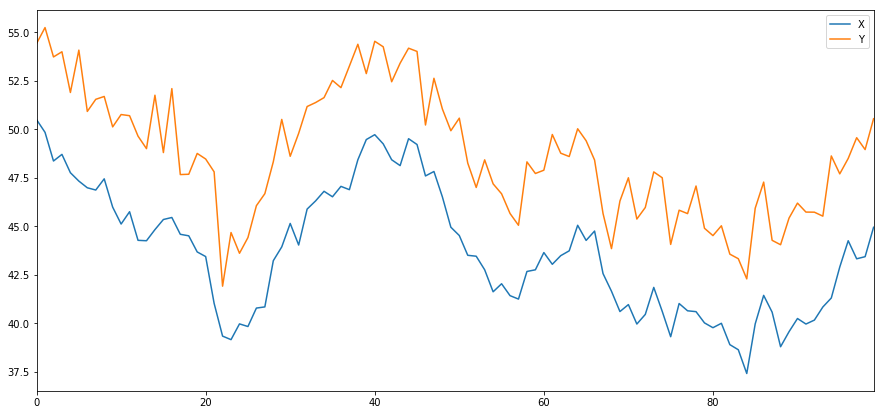

In [22]:
# Generate daily returns for X and Y 
Xreturns = np.random.normal(0, 1, 100) 
# sum them and shift all the prices up
X = pd.Series(np.cumsum(
    Xreturns), name='X') + 50

noise = np.random.normal(0, 1, 100)
Y = X + 5 + noise
Y.name = 'Y'
pd.concat([X, Y], axis=1).plot(figsize=(15,7))

plt.show()

### Hypothetical Framework - Correlation
<a id="five"></a>
[Back to Index](#contents)

Without detailing every theoretical background of the correlation, let's just summarise by saying that it is computed through a correlation coefficient ρ, which ranges from -1 to +1. -1 means negative perfect linear correlation while +1 the counter-opposite, i.e. a perfect positive correlation (when one variable moves in either up or down direction, the other variable also moves in the same direction with the same magnitude). 


In [25]:
#let's check for the correlation between the two time series
X.corr(Y)

#Nice, it seems high! Still...

0.9497090646385932

### Hypothetical Framework - Cointegration
<a id="six"></a>
[Back to Index](#contents)

Cointegration basically refers to the concept of stationarity. The latter refers to a stochastic process whose statistical properties does not change when shifted in time, namely parameters such as mean and variance. This building block is fundamental in statistics as stationary processes are (i) easier to analyze and model thereafter allowing the analyst to create complex model from basic ones or to approximate complex phenomena, and (ii) because such processes are more efficiently predictable, as the way they change is predictable itself.
Wrapping this up for our pairs trading strategy, if the process is stationary this means that the spread between the two stocks should be the same over time, therefore any deviation is an entry/exit signal for the pairs trade. 

We mentioned before the Engle–Granger two-step method, which basically starts from the building block that if xt and yt are non-stationary and cointegrated, then a linear combination of them must be stationary. In other words:
yt−βxt =ut, where ut is stationary.
If we knew ut, we could just test it for stationarity with something like a Dickey–Fuller test, Phillips–Perron test and be done. But because we don’t know ut, we must estimate this first, generally by using ordinary least squares, and then run our stationarity test on the estimated ut series.

A cool concept to explain cointegration has been widely used in the literature and it is the following: the two assets can be a drunk man and a dog, with their spread being the dog's leash. The dog leash would keep both assets in line, but when one of the two is going away (let's say the drunk man has fallen from the sidewalk, or the stock has become too bullish), the investor would short the bullish stock and purchase the bearish one. After multiple time lag, the dog would converge to the drunk man. As said before, this theory holds (as many Fund Manager like to sell), with past data. In fact, the backtesting is made on historical invariants, while in reality the market is dynamic and therefore the drunk man and the dog may diverge because the drunk man calls an Uber (a new product launch, a different market penetration, a change in the management) and forget about the dog, that remains on the sidewalk. 

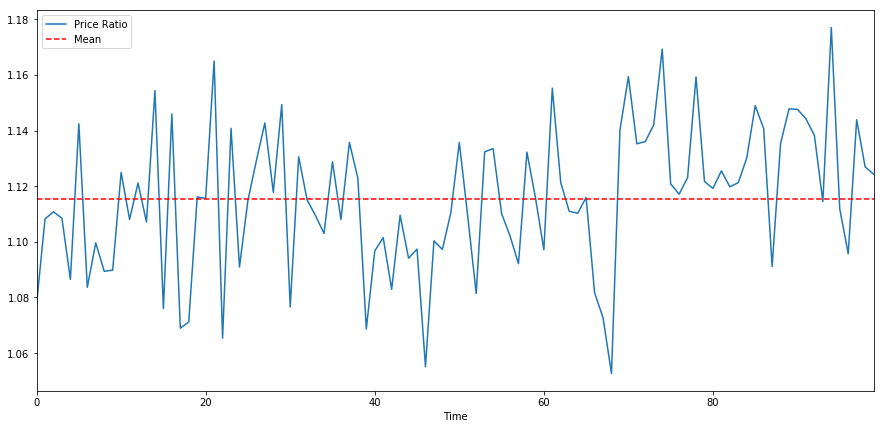

In [23]:
#The two series hypothetically constructed above are cointegrated. Let's test it 

(Y/X).plot(figsize=(15,7)) 
plt.axhline((Y/X).mean(), color='red', linestyle='--') 
plt.xlabel('Time')
plt.legend(['Price Ratio', 'Mean'])
plt.show()

In [24]:
#There is a convenient test that lives in statsmodels.tsa.stattools. 
#In order to understand if the two are really cointegrated, we look at the p-value, 
#which should be as lower as possible (thresold is generally 0.05 for 95% level of confidence)

pvalue = coint(X,Y)
print(pvalue[1])

2.0503418653415035e-16


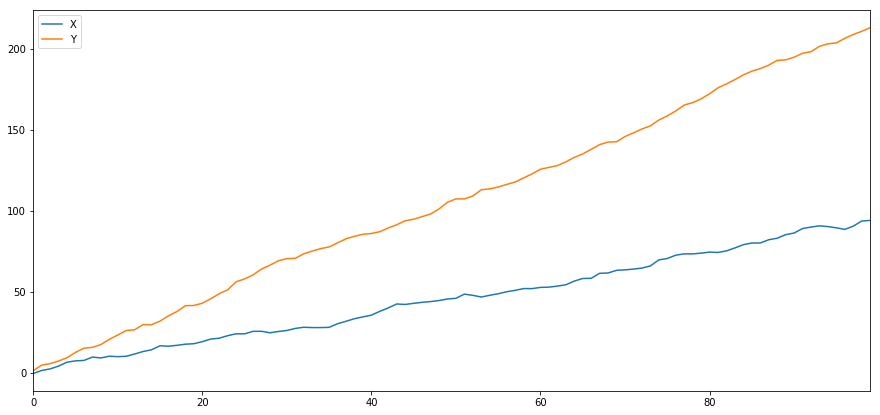

Correlation is 0.9972053074756442
Cointegration test p-value:  0.11056252333156058


In [40]:
#Example of two series that are correlated but not cointegrated (as p-value very high)
ret1 = np.random.normal(1, 1, 100)
ret2 = np.random.normal(2, 1, 100)

s1 = pd.Series( np.cumsum(ret1), name='X')
s2 = pd.Series( np.cumsum(ret2), name='Y')
dataset_hypo = pd.concat([s1, s2])
pd.concat([s1, s2], axis=1 ).plot(figsize=(15,7))
plt.show()
correlation_hypo = s1.corr(s2)
print("Correlation is", correlation_hypo)
pvalue = coint(s1,s2)
print("Cointegration test p-value: ", pvalue[1])

Another way to test for Cointegration is the ADF (Augmented Dicky Fuller) Test, which results is still a p-value that enables us to understand with a confidence level (again, generally 95%) if the series (the spread) is stationary or not. 

In [46]:
from statsmodels.tsa.stattools import adfuller
series = dataset_hypo
K = series.values
result = adfuller(K)
print('ADF Statistic for Hypothetical Test: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic for Hypothetical Test: 0.357102
p-value: 0.979818
Critical Values:
	1%: -3.464
	5%: -2.876
	10%: -2.575


Now comes the trick. As in all market basics, if all investors exploit a market bias, an arbitrage opportunity or a disequilibrium, pretty soon the market will converge back to its equilibrium and efficiency. I bet you thought, well, let's just run a whole script through all the investible universe of all assets and find the paired ones. Let's say a 2 carats D-IF diamond and a 1986 Ferrari Testarossa, or the six pack Guiness beer and AAPL stock. Well, you may result with more false positive than with the current 2019-Coronavirus epidemic. The latter is called Comparisons Bias, which is the probability of resulting with many incorrently-significant (false positive) p-values as higher as the number of test computed is. If 100 tests are run on a random dataset, the investor would expect (as written above) more or less 5 significant p-values below the value of 0.05, while if the investor compares n stocks will perform n(n-1)/2 computations. The number of false positives will increase as n increases.

In [90]:
data_sample1 = quandl.get_table('WIKI/PRICES', ticker = ['AAPL', 'ADBE', 'SYMC', 'MSFT'
                                                        'HPQ','JNPR', 'AMD','IBM'], 
                        qopts = { 'columns': ['Ticker', 'Date', 'Adj_close'] }, 
                        date = { 'gte': '2010-01-01', 'lte': '2018-01-01' }, 
                        paginate=True)

# create a new dataframe with 'date' column as index
new_sample1 = data_sample1.set_index('date')

# use pandas pivot function to sort adj_close by tickers
data_sample1_clean = new_sample1.pivot(columns='ticker')

data_sample1_clean.tail()

adj_close                                     
ticker          AAPL    ADBE    AMD     IBM   JNPR   SYMC
date                                                     
2017-12-22    175.01  175.00  10.54  152.50  28.86  28.32
2017-12-26    170.57  174.44  10.46  152.83  28.86  28.23
2017-12-27    170.60  175.36  10.53  153.13  28.88  28.45
2017-12-28    171.08  175.55  10.55  154.04  28.87  28.48
2017-12-29    169.23  175.24  10.28  153.42  28.50  28.06

In [161]:
# Heatmap to show the p-values of the cointegration test
# between each pair of stocks
ticker = ['AAPL', 'ADBE', 'SYMC', 'MSFT','HPQ','JNPR', 'AMD','IBM']
data_sample1_clean.dropna()

adj_close                                                 
ticker            AAPL    ADBE    AMD         IBM       JNPR       SYMC
date                                                                   
2010-01-04   27.503268   37.09   9.70  108.070985  25.837205  13.404511
2010-01-05   27.550818   37.70   9.71  106.765484  25.428448  13.331660
2010-01-06   27.112585   37.62   9.57  106.071937  24.744019  13.375371
2010-01-07   27.062465   36.89   9.47  105.704765  24.867597  13.346231
2010-01-08   27.242385   36.69   9.43  106.765484  24.953150  13.382656
...                ...     ...    ...         ...        ...        ...
2017-12-22  175.010000  175.00  10.54  152.500000  28.860000  28.320000
2017-12-26  170.570000  174.44  10.46  152.830000  28.860000  28.230000
2017-12-27  170.600000  175.36  10.53  153.130000  28.880000  28.450000
2017-12-28  171.080000  175.55  10.55  154.040000  28.870000  28.480000
2017-12-29  169.230000  175.24  10.28  153.420000  28.500000  28.060000

[2011 rows x 6 columns]

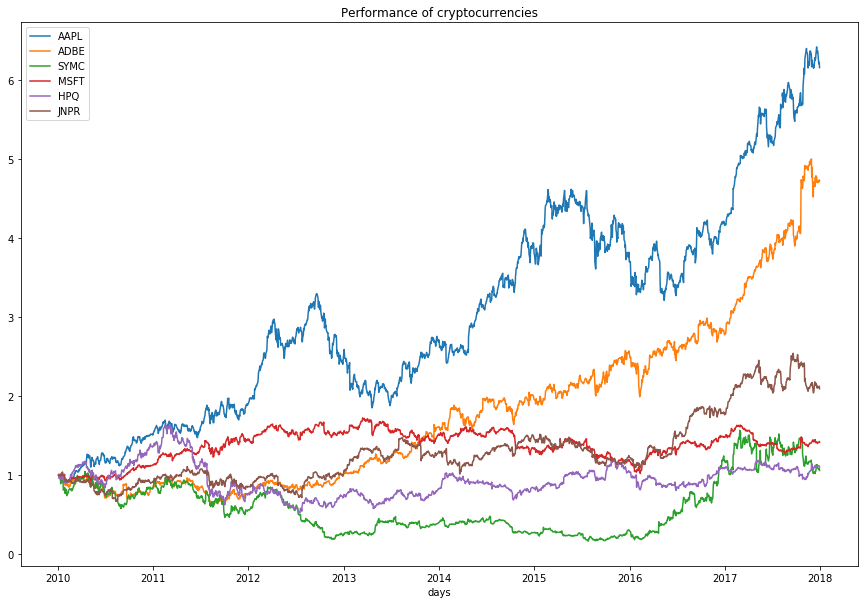

In [178]:
#Dataset visualization
#Normalize prices by first value
norm_prices = data_sample1_clean.divide(data_sample1_clean.iloc[0])

plt.figure(figsize = (15, 10))
plt.plot(norm_prices)
plt.xlabel('days')
plt.title('Performance of cryptocurrencies')
plt.legend(ticker)
plt.show()

The Null hypothesis is that there is no cointegration, the alternative hypothesis is that there is cointegrating relationship. If the pvalue is small, below a critical size, then we can reject the hypothesis that there is no cointegrating relationship

In [1017]:
ticker = ['AAPL', 'MSFT', 'AMZN']
data = quandl.get_table('WIKI/PRICES', ticker = ticker, 
                        qopts = { 'columns': ['ticker', 'date', 'adj_close'] }, 
                        date = { 'gte': '2010-12-31', 'lte': '2018-12-31' }, 
                        paginate=True)
new = data.set_index('date')

clean_data = new.pivot(columns='ticker')

In [1019]:
#Rename columns 
clean_data.columns = range(clean_data.shape[1])
clean_data.columns = ticker
clean_data

,AAPL,MSFT,AMZN
date,,,
2010-12-31,41.453456,180.00,23.153497
2011-01-03,42.354338,184.22,23.211568
2011-01-04,42.575382,185.01,23.300747
2011-01-05,42.923655,187.42,23.228159
2011-01-06,42.888956,185.86,23.908412
...,...,...,...
2018-03-21,171.270000,1581.86,92.480000
2018-03-22,168.845000,1544.10,89.790000
2018-03-23,164.940000,1495.56,87.180000


In [435]:
#Remove NaN in the dataset
clean_data.fillna(method='ffill', inplace=True)

In [436]:
clean_data.isna().sum()

AAPL    0
MSFT    0
AMZN    0
dtype: int64

In [416]:
#Loop with automatic names to create a matrix with the P-Values and the proper pairs
column_names = ticker
df = pd.DataFrame(columns = column_names)
for i in ticker:
    df = df.append(pd.Series(name=i))
df

intersection = df.index & df.columns
for item in intersection:
    for a1 in clean_data.columns:
        for a2 in clean_data.columns:
            if a1 != a2:
                test_result = ts.coint(clean_data[a1], clean_data[a2])
                #aux.append((a1, a2, test_result[1]))
                df.loc[a1, a2] = round(test_result[1], 5)
            elif a1 == a2: 
                df.loc[item, item] = round(0, 5)

df

,AAPL,MSFT,AMZN
AAPL,0,0.68158,0.28082
MSFT,0.95775,0,0.71691
AMZN,0.4696,0.53752,0


In [411]:
#Loop with automatic names to create a dataframe with the P-Values and the proper pairs
aux = []
for a1 in clean_data.columns:
    for a2 in clean_data.columns:
        if a1 != a2:
            test_result = ts.coint(clean_data[a1], clean_data[a2])
            aux.append((a1, a2, test_result[1]))
        elif a1 == a2: 
            aux.append((a1, a2, 0))
    
df = pd.DataFrame(aux) 
df.columns = ["Pair1","Pair2","P_Value"]
df

,Pair1,Pair2,P_Value
0,AAPL,AAPL,0.000000
1,AAPL,MSFT,0.681579
2,AAPL,AMZN,0.280825
3,MSFT,AAPL,0.957747
4,MSFT,MSFT,0.000000
5,MSFT,AMZN,0.716913
6,AMZN,AAPL,0.469600
7,AMZN,MSFT,0.537518
8,AMZN,AMZN,0.000000


In [412]:
pivoted_table = df.pivot(index='Pair1', columns='Pair2', values='P_Value')
pivoted_table.fillna(0, inplace=True)

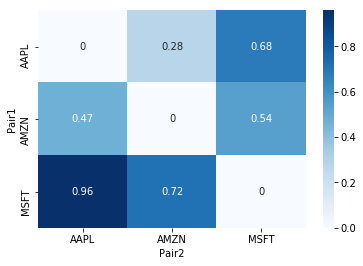

In [413]:
heat_map = sb.heatmap(pivoted_table, cmap="Blues", annot=True)

Extend to more stocks 

In [2]:
#Different method to download data with yfinance

import yfinance as yf
ticker = ['GOOG','AAPL','MCD','MSFT','F','HON','HPQ','JPM']
start_date = '2010-01-01'
end_date = '2019-12-31'

spx_prices = pd.DataFrame(columns=ticker)
for a in ticker:
    print('Downloading ' + a)
    spx_prices[a] = yf.download(a,start_date,end_date)['Adj Close']

#Check if NaN 
#data.isna().sum()

spx_prices.head()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,GOOG,AAPL,MCD,MSFT,F,HON,HPQ,JPM
Date,,,,,,,,
2009-12-31,308.832428,26.131752,45.660534,23.925440,7.028978,29.438734,15.943256,32.327969
2010-01-04,312.204773,26.538483,45.909164,24.294369,7.225790,30.302366,16.234196,33.283356
2010-01-05,310.829926,26.584366,45.558159,24.302216,7.703759,30.362434,16.302296,33.928047
2010-01-06,302.994293,26.161509,44.936562,24.153070,7.991947,30.362434,16.150625,34.114464
2010-01-07,295.940735,26.113146,45.265656,23.901886,8.195788,30.948210,16.156816,34.790226


In [3]:
df_matrix = pd.DataFrame(columns=ticker)
for i in ticker:
    df_matrix = df_matrix.append(pd.Series(name=i))

In [4]:
intersection = df_matrix.index & df_matrix.columns
for item in intersection:
    for a1 in spx_prices.columns:
        for a2 in spx_prices.columns:
            if a1 != a2:
                test_result = ts.coint(spx_prices[a1], spx_prices[a2])
                df_matrix.loc[a1, a2] = round(test_result[1], 5)
            elif a1 == a2: 
                df_matrix.loc[item, item] = round(0, 5)

In [5]:
df_matrix

,GOOG,AAPL,MCD,MSFT,F,HON,HPQ,JPM
GOOG,0,0.61987,0.18978,0.8343,0.99294,0.00441,0.49195,0.05749
AAPL,0.7768,0,0.39118,0.16524,1,0.83592,0.9365,0.15634
MCD,0.14795,0.23317,0,0.35146,0.97913,0.16947,0.448,0.10706
MSFT,0.96512,0.16645,0.78288,0,1,0.98046,0.94915,0.58179
F,0.12217,0.10491,0.09467,0.09658,0,0.13328,0.11946,0.11769
HON,0.00382,0.65672,0.14045,0.88471,1,0,0.40457,0.27184
HPQ,0.27619,0.41603,0.26871,0.48044,0.89696,0.25292,0,0.26384
JPM,0.08916,0.10436,0.17881,0.20408,1,0.39566,0.67296,0


In [6]:
#Loop with automatic names to create a dataframe with the P-Values and the proper pairs
aux = []
for a1 in spx_prices.columns:
    for a2 in spx_prices.columns:
        if a1 != a2:
            test_result = ts.coint(spx_prices[a1], spx_prices[a2])
            aux.append((a1, a2, test_result[1]))
        elif a1 == a2: 
            aux.append((a1, a2, 0))
    
df = pd.DataFrame(aux) 
df.columns = ["Pair1","Pair2","P_Value"]
df

,Pair1,Pair2,P_Value
0,GOOG,GOOG,0.000000
1,GOOG,AAPL,0.619875
2,GOOG,MCD,0.189780
3,GOOG,MSFT,0.834301
4,GOOG,F,0.992939
...,...,...,...
59,JPM,MSFT,0.204077
60,JPM,F,1.000000
61,JPM,HON,0.395657
62,JPM,HPQ,0.672955


In [7]:
pivoted_table = df.pivot(index='Pair1', columns='Pair2', values='P_Value')
pivoted_table.fillna(0, inplace=True)

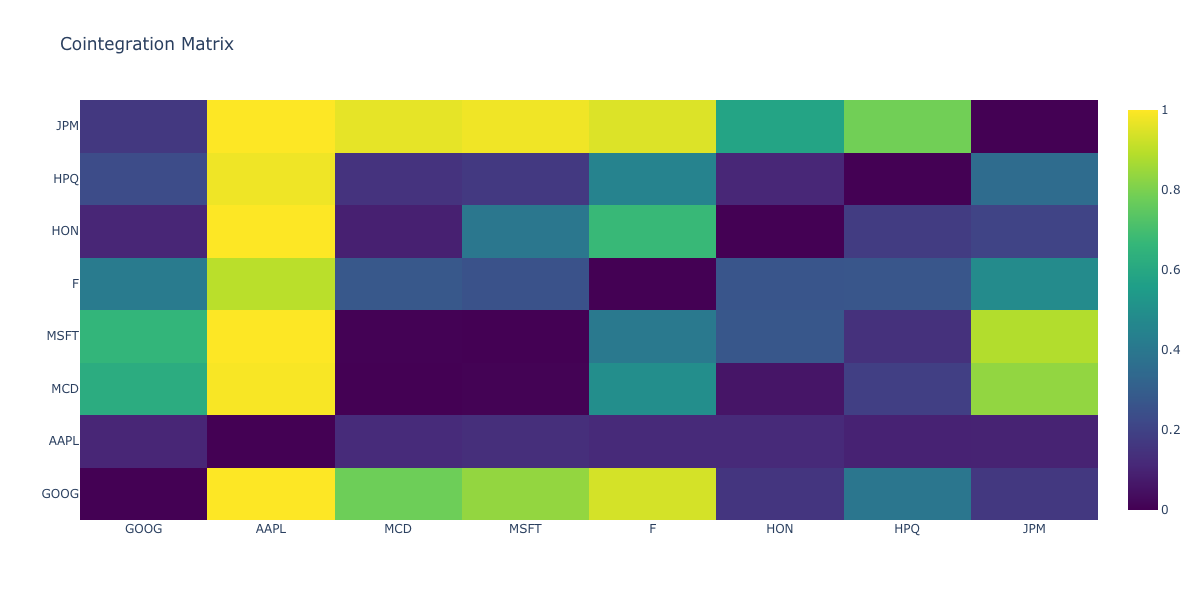

In [44]:
fig = go.Figure(data=go.Heatmap(
        z=pivoted_table,
        x=ticker,
        y=ticker,
        colorscale='Viridis'))

fig.update_layout(
    title='Cointegration Matrix',
    xaxis_nticks=36)

fig.show(renderer="png", width=1200, height=600)
#IMPORTANT: to exploit the full potential of PlotLy, in a jupiter notebook or 
#whatever, please use fig.show(). This will allow to have an interactive chart 
#that it's unfortunately not supported in Github atm. 

In [9]:
#Sorting with ascending order
df_sorted = df.sort_values(by=["P_Value"])
df_sorted

,Pair1,Pair2,P_Value
0,GOOG,GOOG,0.000000
54,HPQ,HPQ,0.000000
45,HON,HON,0.000000
36,F,F,0.000000
27,MSFT,MSFT,0.000000
...,...,...,...
4,GOOG,F,0.992939
28,MSFT,F,1.000000
44,HON,F,1.000000
60,JPM,F,1.000000


In [1036]:
#Removing the same pair
df_sorted_2 = df_sorted[df_sorted.Pair1 != df_sorted.Pair2]

In [1035]:
#Creating a final dataframe with only pairs that have a p-value < 0.05 (threshold that you may change)
df_sorted_3 = df_sorted_2[df_sorted_2.P_Value < 0.05]
df_sorted_3

,Pair1,Pair2,P_Value
40,HON,GOOG,0.003821
5,GOOG,HON,0.004410


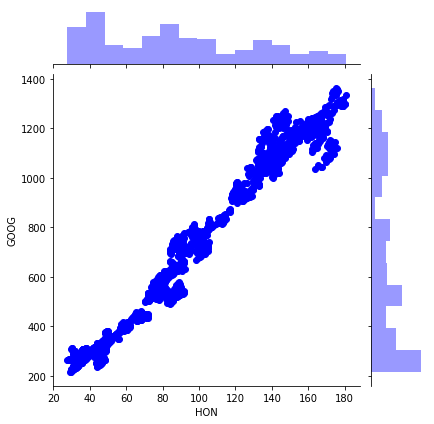

In [1057]:
sns.jointplot(spx_prices["HON"], spx_prices["GOOG"],color='b')
plt.show()

Further update: use Eagle-Granger Two-Step Method for cointegration in order to compare it with the close-end library given by stats-model. Theory @ [this](https://warwick.ac.uk/fac/soc/economics/staff/gboero/personal/hand2_cointeg.pdf). Let's now move on to the next steps of our analysis.

### Hypothetical Framework - Spread & Entry/Exit Signals
<a id="seven"></a>
[Back to Index](#contents)

It seems that HON & GOOG are very much cointegrated. Let's see if looking at the price of the two, this makes sense (qualitative analysis). 

0.0038206559749957626


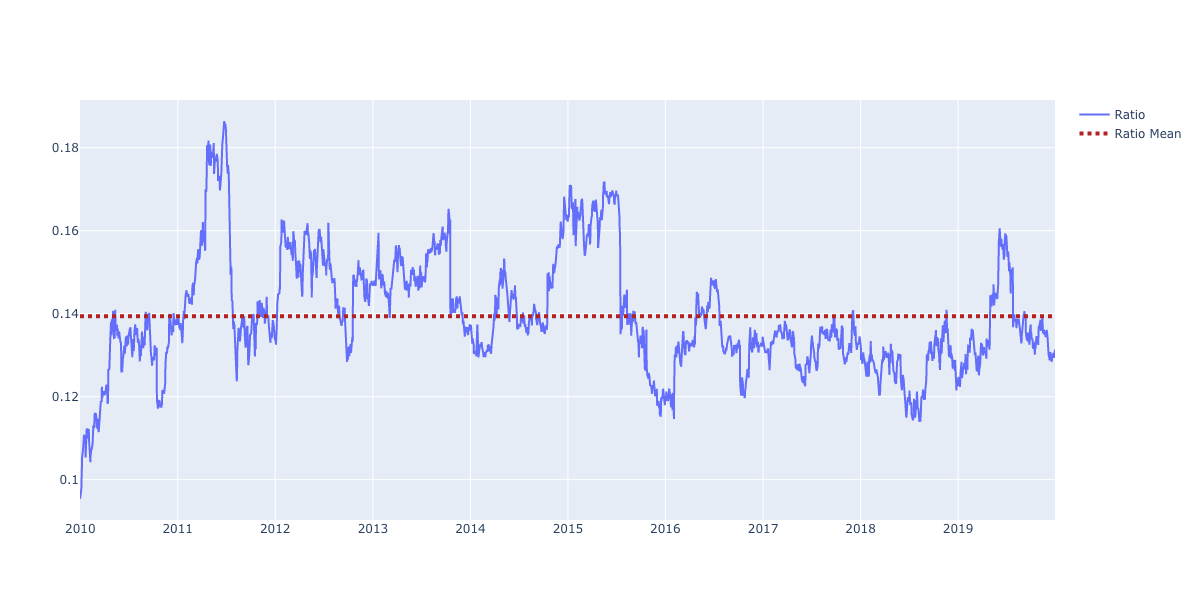

In [43]:
S1 = spx_prices['HON']
S2 = spx_prices['GOOG']
score, pvalue, _ = ts.coint(S1, S2)
print(pvalue)
ratios = S1 / S2

#This creates a dataframe of the Ratio series just to use PlotLy 
ratios.head()
ratios_df = pd.DataFrame(ratios) 
#Rename columns 
ratios_df.columns = range(ratios_df.shape[1])
#del ratios_df.index.name  
ratios_df.index.name = "Dates"
ratios_df.columns = ["Ratio"]
ratios_df.reset_index(level=0, inplace=True)
ratios_df['Mean'] = ratios_df["Ratio"].mean()

#To plot with PlotLy 
random_x = ratios_df["Dates"]
random_y0 = ratios_df["Ratio"]
random_y1 = ratios_df["Mean"]

# Create two lines, ratios and mean 
fig = go.Figure()
fig.add_trace(go.Scatter(x=random_x, y=random_y0,
                    mode='lines',
                    name='Ratio'))
fig.add_trace(go.Scatter(x=random_x, y=random_y1,
                    mode='lines',
                    name='Ratio Mean', 
                    line=dict(color='firebrick', width=4, dash='dot')))

fig.show(renderer="png", width=1200, height=600)

#Looking at this ratio, it is pretty conceivable that the two moved pretty much around a mean value. 
#To test the vice-versa simply plot two series with a very high P-value 

This absolute ratio is useful if we look at a qualitative first-look analysis, while in statistical term it is not oc very precise. Therefore, a way to understand if the ratio mirrors the cointegration result is to look at a z-score, which is computed as = (Value — Mean) / Standard Deviation. Note that this assumes a normal distribution of the invariants of the stocks. As we know from the far-detailed critiques of Prof Taleb, it is very risk to assume normality where there is no sign of it, as this may lead to significant losses. The true distribution of ratios could be very fat-tailed and prone to extreme values. 


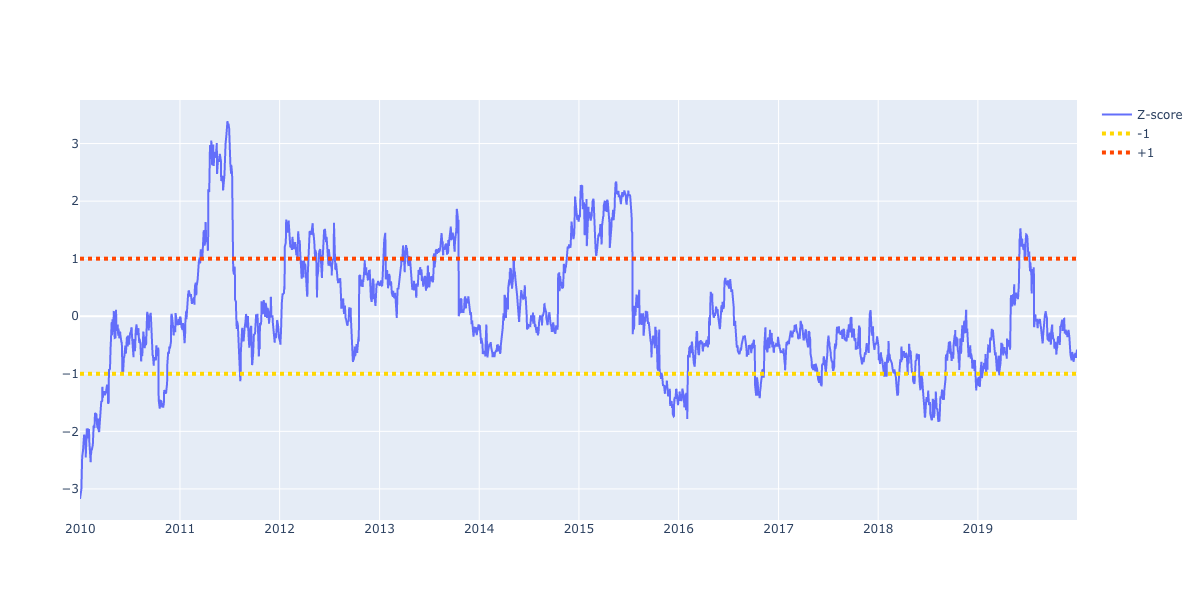

In [42]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

#This creates a dataframe of the Ratio series just to use PlotLy 
ratios_df['Zscore'] = zscore(ratios_df["Ratio"])
ratios_df['-1'] = -1
ratios_df['+1'] = +1

#To plot with PlotLy 
random_x = ratios_df["Dates"]
random_y1 = ratios_df["Zscore"]
random_y2 = ratios_df['-1']
random_y3 = ratios_df['+1']

# Create two lines, ratios and mean 
fig = go.Figure()
fig.add_trace(go.Scatter(x=random_x, y=random_y1,
                    mode='lines',
                    name='Z-score'))
fig.add_trace(go.Scatter(x=random_x, y=random_y2,
                    mode='lines',
                    name='-1', 
                    line=dict(color='gold', width=4, dash='dot')))
fig.add_trace(go.Scatter(x=random_x, y=random_y3,
                    mode='lines',
                    name='+1', 
                    line=dict(color='orangered', width=4, dash='dot')))

fig.show(renderer="png", width=1200, height=600)


Let's now compute an ADF (Augmented Dickey-Fuller test), just to have a relative evaluation. The latter, without a detailed explanation, tests the null hypothesis that a unit root is present in a time series sample. The alternative hypothesis is different depending on which version of the test is used, but is usually stationarity, which is what concerns us in this regard. The intuition behind the test is that if the series is characterised by a unit root process then the lagged level of the series will provide no relevant information in predicting the change, besides the one obtained in the lagged changes. In this case the gamma and null hypothesis is not rejected. In contrast, when the process has no unit root, it is stationary and hence exhibits reversion to the mean - so the lagged level will provide relevant information in predicting the change of the series and the null of a unit root will be rejected.

In a nutshell the unit root test for non-stationarity of variables: 
- Null Hypothesis: The series has a unit root (value of a = 1)
- Alternate Hypothesis: The series has no unit root.
If we fail to reject the null hypothesis, we can say that the series is non-stationary, i.e. if p-value <= 0.05 we do reject the null hypothesis (H0) and the data does not have a unit root.

In [1071]:
from statsmodels.tsa.stattools import adfuller
series = ratios_df["Ratio"].dropna()
X = series.values
result = adfuller(X)
print('ADF Statistic for Spread Ratio: %f' % result[0])
print('P-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic for Spread Ratio: -4.304476
P-value: 0.000436
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


From this we can see that the test statistic of is larger in absolute terms than the 3 tests critical values, i.e. 1%, 5% and 10%. This means that we accept the null hypothesis that there is a unit root in the spread time series, and it is therefore mean reverting. This is confirmed by the P-Value as well, which is lower than the threshold for 90%, 95% and 99% confidence level. 

Another test that we can do on our ratio is the Hurst exponent (H). To simplify things, the important info to remember here is that a time series can be characterised in the following manner with regard to the Hurst exponent (H): 
- H < 0.5, The time series is mean reverting 
- H = 0.5, The time series is a Geometric Brownian Motion 
- H > 0.5, The time series is trending

In [1093]:
H, c, data = compute_Hc(ratios_df["Ratio"])
print("Hurst Exponent =",round(H,2)) 

Hurst Exponent = 0.45


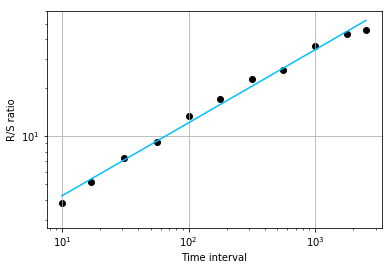

H=0.4541, c=1.4949


In [1098]:
# Plot
f, ax = plt.subplots()
ax.plot(data[0], c*data[0]**H, color="deepskyblue")
ax.scatter(data[0], data[1], color="black")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Time interval')
ax.set_ylabel('R/S ratio')
ax.grid(True)
plt.show()

print("H={:.4f}, c={:.4f}".format(H,c))

Therefore, seen H < 0.5, we can conclude the ratio is mean reverting. Moreover, the same conclusion was achieved thanks to the ADF test, cool. Always keep in mind that if the ratio is mean-reverting, this does not mean we should trade it. The timing is fundamental, like if your're waiting for your girl/boy at a restaurant. You're sure she or he will arrive at one point in the foreseeable future, but definitely you don't want to wait 5 years at the table. To understand this better, the literature refers to the half-life theory: merely, this encompasses an exponential decay equation, i.e. the time required for a quantity to reduce to half of its initial value. The term is commonly used in nuclear physics to describe how quickly unstable atoms undergo, or how long stable atoms survive, radioactive decay. The term is also used more generally to characterize any type of exponential or non-exponential decay. For example, the medical sciences refer to the biological half-life of drugs and other chemicals in the human body. 

What the investor can do now is to compute an OLS regression between the spread series and a lagged version of itself. The Beta coefficient produced by this regression can then be incorporated into the Ornstein-Uhlenbeck (more info [here](https://mathtopics.wordpress.com/2013/01/07/ornstein-uhlenbeck-process/)) process to calculate the half-life.




In [1101]:
#Run OLS regression on spread series and lagged version of itself
spread_lag = ratios_df["Ratio"].shift(1)
spread_lag.loc[0] = spread_lag.loc[1]
spread_ret = ratios_df["Ratio"] - spread_lag
spread_ret.loc[0] = spread_ret.loc[1]
spread_lag2 = sm.add_constant(spread_lag)

model = sm.OLS(spread_ret,spread_lag2)
res = model.fit()


halflife = round(-np.log(2) / res.params[1],0)

print('Halflife = ',halflife)

Halflife =  56.0


In [1104]:
results_OLS = sm.OLS(spread_ret,spread_lag2).fit()

print(results_OLS.summary())

                            OLS Regression Results                            
Dep. Variable:                  Ratio   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     18.93
Date:                Thu, 05 Mar 2020   Prob (F-statistic):           1.41e-05
Time:                        19:36:49   Log-Likelihood:                 12074.
No. Observations:                2516   AIC:                        -2.414e+04
Df Residuals:                    2514   BIC:                        -2.413e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.000      4.367      0.0

The half life is not to bad, being 56. Ideally the half-life would be as short as possible so as to provide us with more profitable trading opportunities (and windows, as discussed below)

We are now able to see that the graw stays within the mean, but it is sometimes prone to go out the (-1;+1) range. These are the entry and exit signal we may use. Now, it is time to compute the true entry/exit point signal. To do so, it's fundamental to understand the accuracy of the model, therefore the analyst needs to split it in train (let's say 70% of the data) & test (remaining 30%). 

Thereafter, to understand entry/exit signal, we'll use multiple statistical and trading features. The latter, after having found a proper pair of stocks, really determines the ability of the model to be efficient. 

We'll use as measure:
- 60 day Moving Average of Ratio: Measure of rolling mean
- 5 day Moving Average of Ratio: Measure of current value of mean
- 60 day Standard Deviation
- z score: (5d MA — 60d MA) /60d SD

In [760]:
print("Total values observations are: ", len(ratios_df["Ratio"]), 
      ", we will use:", round(len(ratios_df["Ratio"]) * 0.7,0), 
     " values to train the model and ", round(len(ratios_df["Ratio"]) * 0.3,0), " values to test")


Total values observations are:  2516 , we will use: 1761.0  values to train the model and  755.0  values to test


In [18]:
train_value = int(round(len(ratios_df["Ratio"]) * 0.7,0))
test_value = int(round(len(ratios_df["Ratio"]) * 0.3,0))
train = ratios_df["Ratio"][:train_value]
test = ratios_df["Ratio"][train_value:]
len(test) == test_value

True

In [19]:
ratios_mavg5 = train.rolling(window=5,
                               center=False).mean()
ratios_mavg60 = train.rolling(window=60,
                               center=False).mean()
std_60 = train.rolling(window=60,
                        center=False).std()
zscore_60_5 = (ratios_mavg5 - ratios_mavg60)/std_60

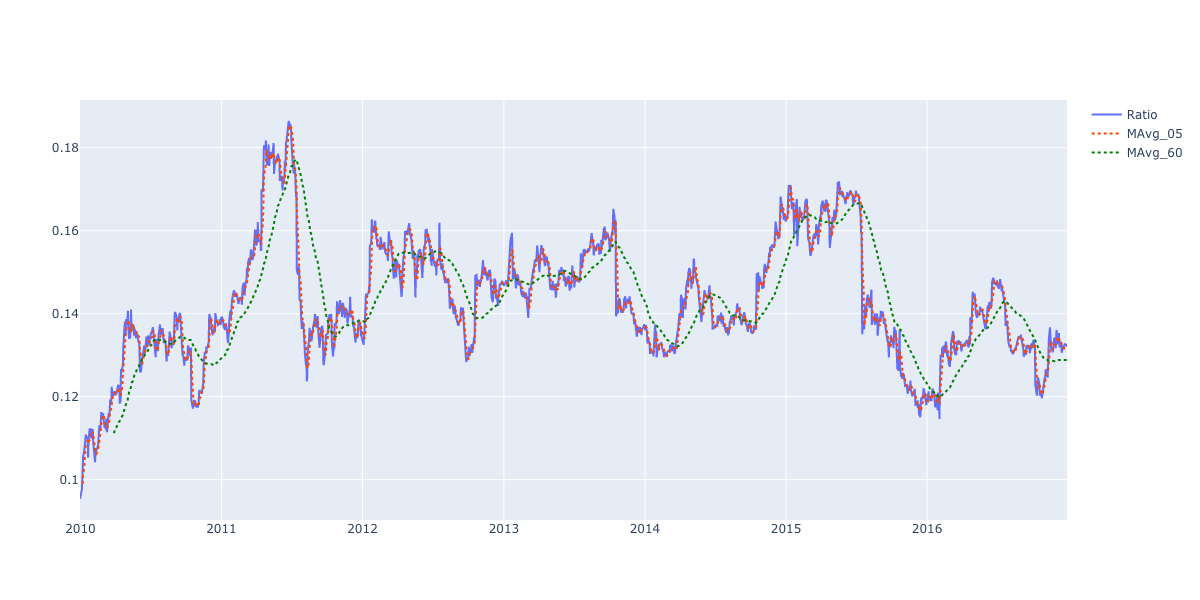

In [41]:
#This creates a dataframe of the Ratio series and various MAvg - StDev just to use PlotLy 
ratios_df_second = pd.DataFrame(train) 
ratios_df_second['MAvg_05'] = ratios_mavg5
ratios_df_second['MAvg_60'] = ratios_mavg60
ratios_df_second['Std_60'] = std_60
ratios_df_second['Z_score_60_5'] = zscore_60_5
ratios_df_second['Dates'] = ratios_df["Dates"]

#To plot with PlotLy 
random_x = ratios_df["Dates"]
random_y0 = ratios_df_second['Ratio'] 
random_y1 = ratios_df_second['MAvg_05']
random_y2 = ratios_df_second['MAvg_60']

# Create two lines, ratios and mean 
fig = go.Figure()
fig.add_trace(go.Scatter(x=random_x, y=random_y0,
                    mode='lines',
                    name='Ratio'))
fig.add_trace(go.Scatter(x=random_x, y=random_y1,
                    mode='lines',
                    name='MAvg_05', 
                    line=dict(color='orangered', width=2, dash='dot')))
fig.add_trace(go.Scatter(x=random_x, y=random_y2,
                    mode='lines',
                    name='MAvg_60', 
                    line=dict(color='green', width=2, dash='dot')))

fig.show(renderer="png", width=1200, height=600)

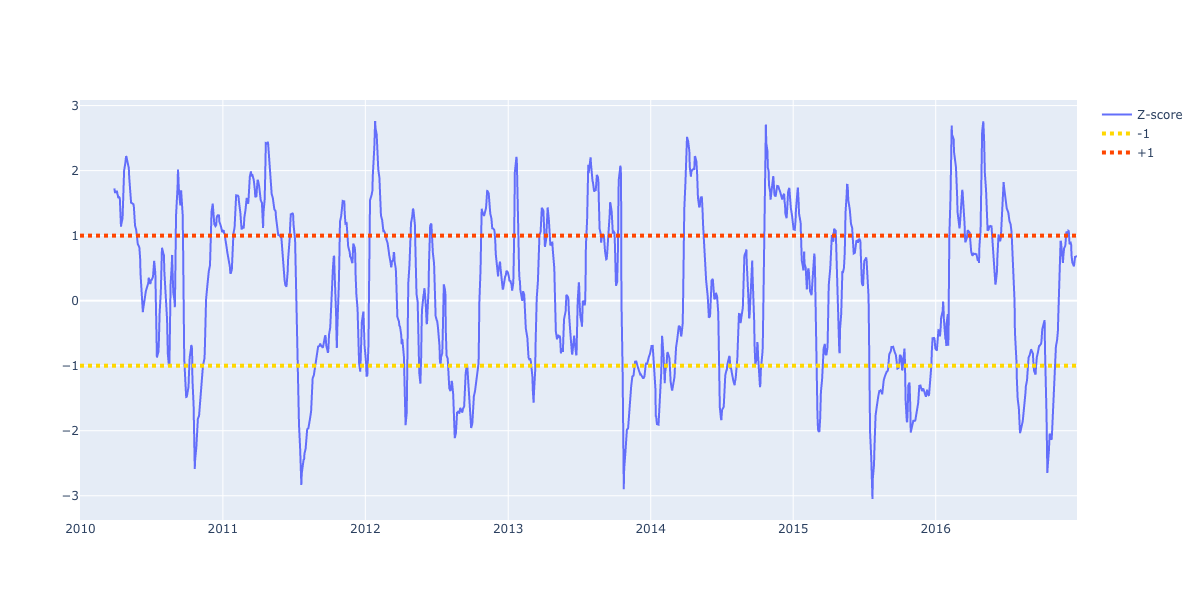

In [40]:
#This creates a dataframe of the Ratio series just to use PlotLy 
ratios_df_third = pd.DataFrame(zscore_60_5) 
ratios_df_third['-1'] = -1
ratios_df_third['+1'] = +1

#To plot with PlotLy 
random_x = ratios_df_second["Dates"]
random_y1 = ratios_df_third["Ratio"]
random_y2 = ratios_df_third['-1']
random_y3 = ratios_df_third['+1']

# Create two lines, ratios and mean, along with +1 and -1
fig = go.Figure()
fig.add_trace(go.Scatter(x=random_x, y=random_y1,
                    mode='lines',
                    name='Z-score'))
fig.add_trace(go.Scatter(x=random_x, y=random_y2,
                    mode='lines',
                    name='-1', 
                    line=dict(color='gold', width=4, dash='dot')))
fig.add_trace(go.Scatter(x=random_x, y=random_y3,
                    mode='lines',
                    name='+1', 
                    line=dict(color='orangered', width=4, dash='dot')))

fig.show(renderer="png", width=1200, height=600)

At this point, the entry/exit signals become more clear. In fact, we may see with the Z-score computed as so that when the value get's too high, it tends to revert back in the mean region and vice-versa. Therefore: 
- Ratio is buy (1) whenever the z-score is below -1.0 because we expect z score to go back up in the mean zone, hence ratio to increase
- Ratio is sell(-1) when the z-score is above 1.0 because we expect z score to go back down to 0, hence ratio to decrease

In [22]:
buy = train.copy()
sell = train.copy()
train = train.copy()
ratios_df_fourth = pd.DataFrame(train) 
ratios_df_fourth.columns = range(ratios_df_fourth.shape[1])
ratios_df_fourth.columns = ["Train"]
ratios_df_fourth['Buy'] = sell
ratios_df_fourth['Sell'] = sell
ratios_df_fourth['Dates'] = ratios_df["Dates"]

ratios_df_fourth['Buy'][zscore_60_5>-1] = ""
ratios_df_fourth['Sell'][zscore_60_5<1] = ""
ratios_df_fourth

,Train,Buy,Sell,Dates
0,0.095323,0.0953227,0.0953227,2009-12-31
1,0.097059,0.0970593,0.0970593,2010-01-04
2,0.097682,0.0976818,0.0976818,2010-01-05
3,0.100208,0.100208,0.100208,2010-01-06
4,0.104576,0.104576,0.104576,2010-01-07
...,...,...,...,...
1756,0.132110,,,2016-12-21
1757,0.132344,,,2016-12-22
1758,0.132649,,,2016-12-23
1759,0.132420,,,2016-12-27


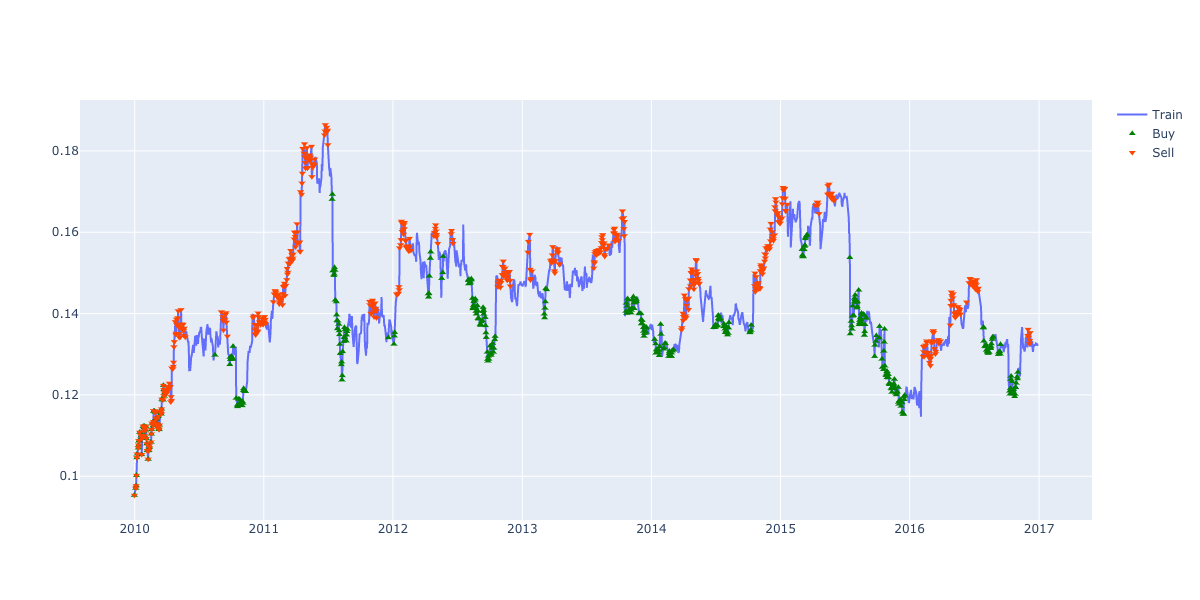

In [39]:
#To plot with PlotLy 
random_x = ratios_df_fourth["Dates"]
random_y0 = ratios_df_fourth["Train"]
random_y1 = ratios_df_fourth["Buy"]
random_y2 = ratios_df_fourth['Sell']

# Create two lines, ratios and mean and all the signals 
fig = go.Figure()
fig.add_trace(go.Scatter(x=random_x, y=random_y0,
                    mode='lines',
                    name='Train'))

fig.add_trace(go.Scatter(x=random_x, y=random_y1,
                    mode='markers', marker_symbol="triangle-up",
                    name='Buy', 
                    marker=dict(color='green',
                    size=6,
                    opacity=1)))
fig.add_trace(go.Scatter(x=random_x, y=random_y2,
                    mode='markers', marker_symbol="triangle-down",
                    name='Sell', 
                    marker=dict(color='orangered',
                    size=6,
                    opacity=1)))
fig.show(renderer="png", width=1200, height=600)

Let's now plot the prices and Buy/Sell signals from Z-score computed above 

In [24]:
S1 = spx_prices['HON'].iloc[:train_value]
S2 = spx_prices['GOOG'].iloc[:train_value]

In [25]:
ratios_df_fifth = pd.DataFrame(S1) 
ratios_df_fifth['GOOG'] = S2

ratios_df_fifth.reset_index(level=0, inplace=True)
ratios_df_fifth.columns = range(ratios_df_fifth.shape[1])
ratios_df_fifth.columns = ["Dates", "HON", "GOOG"]

ratios_df_fifth

,Dates,HON,GOOG
0,2009-12-31,29.438734,308.832428
1,2010-01-04,30.302366,312.204773
2,2010-01-05,30.362434,310.829926
3,2010-01-06,30.362434,302.994293
4,2010-01-07,30.948210,295.940735
...,...,...,...
1756,2016-12-21,104.968987,794.559998
1757,2016-12-22,104.718193,791.260010
1758,2016-12-23,104.780884,789.909973
1759,2016-12-27,104.816696,791.549988


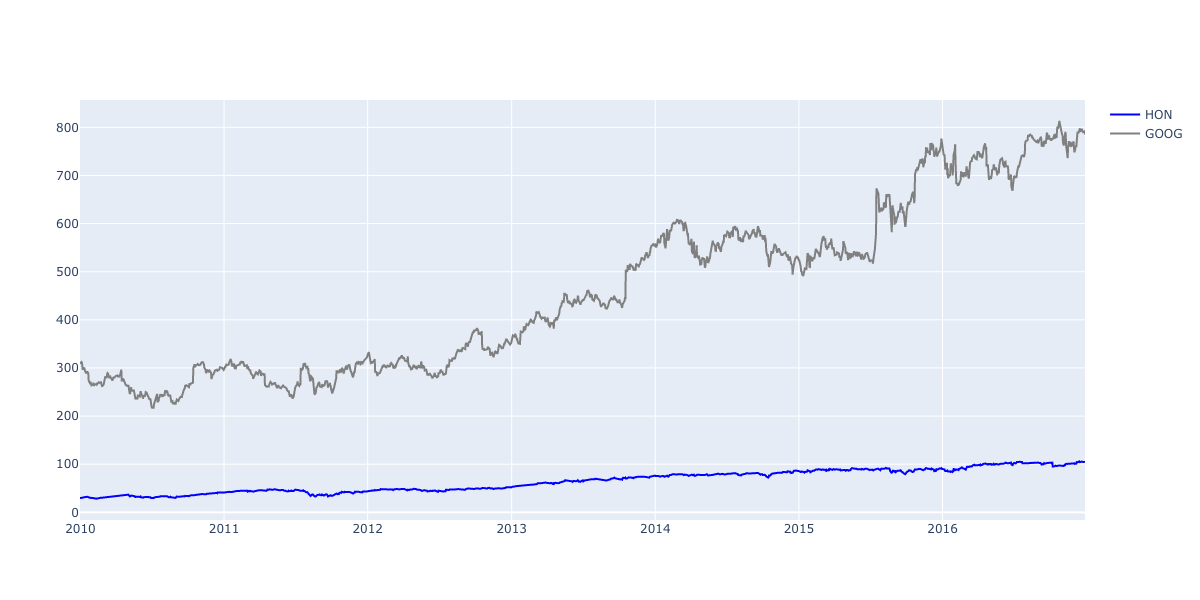

In [38]:
random_x = ratios_df_fifth["Dates"]
random_y0 = ratios_df_fifth["HON"]
random_y1 = ratios_df_fifth["GOOG"]

# Create two lines, ratios and mean 
fig = go.Figure()
fig.add_trace(go.Scatter(x=random_x, y=random_y0,
                    mode='lines',
                    name='HON', 
                    line=dict(color='blue', width=2)))
fig.add_trace(go.Scatter(x=random_x, y=random_y1,
                    mode='lines',
                    name='GOOG', 
                    line=dict(color='grey', width=2)))
fig.show(renderer="png", width=1200, height=600)

In [27]:
#Normalization to see better the entry/exit signal 
# Plot the prices 
S1 = spx_prices['HON'].iloc[:train_value]
S2 = spx_prices['GOOG'].iloc[:train_value]
ratios_df_fifth = pd.DataFrame(S1) 
ratios_df_fifth['GOOG'] = S2
norm_prices_2 = ratios_df_fifth.divide(ratios_df_fifth.iloc[0])
norm_prices_2.reset_index(level=0, inplace=True)
norm_prices_2.columns = range(norm_prices_2.shape[1])
norm_prices_2.columns = ["Dates", "HON", "GOOG"]
norm_prices_2

,Dates,HON,GOOG
0,2009-12-31,1.000000,1.000000
1,2010-01-04,1.029337,1.010920
2,2010-01-05,1.031377,1.006468
3,2010-01-06,1.031377,0.981096
4,2010-01-07,1.051275,0.958257
...,...,...,...
1756,2016-12-21,3.565676,2.572787
1757,2016-12-22,3.557157,2.562101
1758,2016-12-23,3.559286,2.557730
1759,2016-12-27,3.560503,2.563040


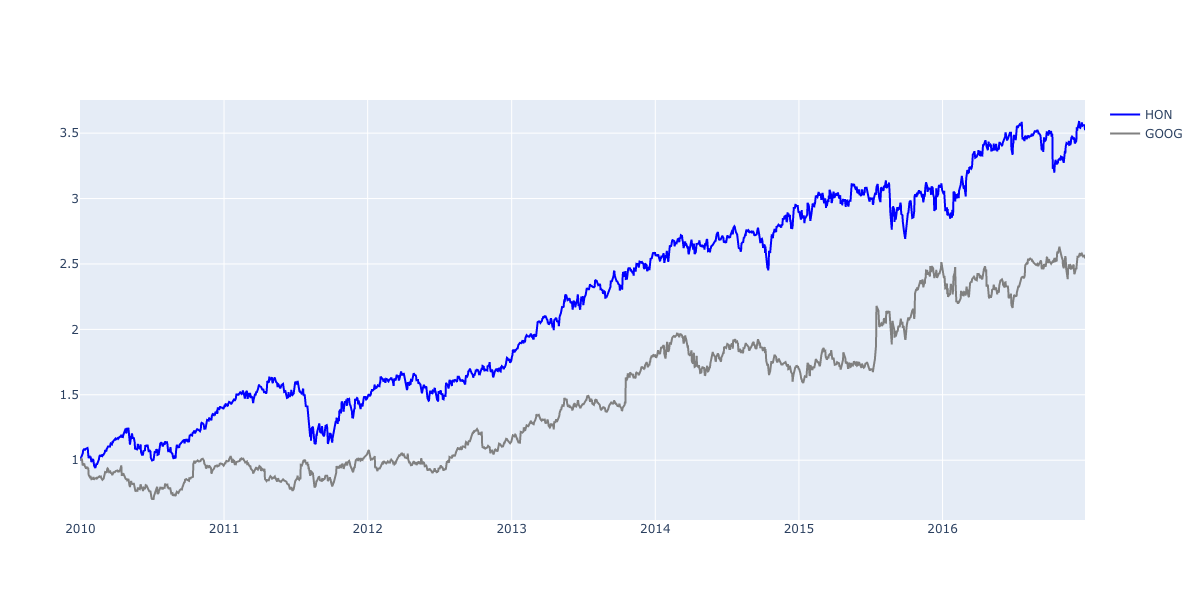

In [37]:
random_x = norm_prices_2["Dates"]
random_y0 = norm_prices_2["HON"]
random_y1 = norm_prices_2["GOOG"]

fig = go.Figure()
fig.add_trace(go.Scatter(x=random_x, y=random_y0,
                    mode='lines',
                    name='HON', 
                    line=dict(color='blue', width=2)))
fig.add_trace(go.Scatter(x=random_x, y=random_y1,
                    mode='lines',
                    name='GOOG', 
                    line=dict(color='grey', width=2)))
fig.show(renderer="png", width=1200, height=600)

In [29]:
buy = train.copy()
sell = train.copy()
train = train.copy()
ratios_df_fourth = pd.DataFrame(train) 
ratios_df_fourth.columns = range(ratios_df_fourth.shape[1])
ratios_df_fourth.columns = ["Train"]
ratios_df_fourth['Buy'] = sell
ratios_df_fourth['Sell'] = sell
ratios_df_fourth['Dates'] = ratios_df["Dates"]

ratios_df_fourth['Buy'][zscore_60_5>-1] = ""
ratios_df_fourth['Sell'][zscore_60_5<1] = ""
ratios_df_fourth

,Train,Buy,Sell,Dates
0,0.095323,0.0953227,0.0953227,2009-12-31
1,0.097059,0.0970593,0.0970593,2010-01-04
2,0.097682,0.0976818,0.0976818,2010-01-05
3,0.100208,0.100208,0.100208,2010-01-06
4,0.104576,0.104576,0.104576,2010-01-07
...,...,...,...,...
1756,0.132110,,,2016-12-21
1757,0.132344,,,2016-12-22
1758,0.132649,,,2016-12-23
1759,0.132420,,,2016-12-27


In [30]:
S1 = spx_prices['HON'].iloc[:train_value]
S2 = spx_prices['GOOG'].iloc[:train_value]
ratios_df_fifth = pd.DataFrame(S1) 
ratios_df_fifth['GOOG'] = S2

ratios_df_fifth.reset_index(level=0, inplace=True)
ratios_df_fifth.columns = range(ratios_df_fifth.shape[1])
ratios_df_fifth.columns = ["Dates", "HON", "GOOG"]

ratios_df_fifth

,Dates,HON,GOOG
0,2009-12-31,29.438734,308.832428
1,2010-01-04,30.302366,312.204773
2,2010-01-05,30.362434,310.829926
3,2010-01-06,30.362434,302.994293
4,2010-01-07,30.948210,295.940735
...,...,...,...
1756,2016-12-21,104.968987,794.559998
1757,2016-12-22,104.718193,791.260010
1758,2016-12-23,104.780884,789.909973
1759,2016-12-27,104.816696,791.549988


In [31]:
buyR = 0*norm_prices_2["HON"].copy()
sellR = 0*norm_prices_2["HON"].copy()

ratios_df_7 = pd.DataFrame(buyR) 
ratios_df_7['sellR'] = sellR

ratios_df_7.columns = ["buyR", "sellR"]
ratios_df_7

,buyR,sellR
0,0.0,0.0
1,0.0,0.0
2,0.0,0.0
3,0.0,0.0
4,0.0,0.0
...,...,...
1756,0.0,0.0
1757,0.0,0.0
1758,0.0,0.0
1759,0.0,0.0


In [32]:
# When buying the ratio, buy S1 and sell S2
ratios_df_7['buyR'][ratios_df_fourth['Buy']!=""] = norm_prices_2["HON"][ratios_df_fourth['Buy']!=""]
ratios_df_7['sellR'][ratios_df_fourth['Buy']!=""] = norm_prices_2["GOOG"][ratios_df_fourth['Buy']!=""]

# When selling the ratio, sell S1 and buy S2 
ratios_df_7['buyR'][ratios_df_fourth['Sell']!=""] = norm_prices_2["GOOG"][ratios_df_fourth['Sell']!=""]
ratios_df_7['sellR'][ratios_df_fourth['Sell']!=""] = norm_prices_2["HON"][ratios_df_fourth['Sell']!=""]


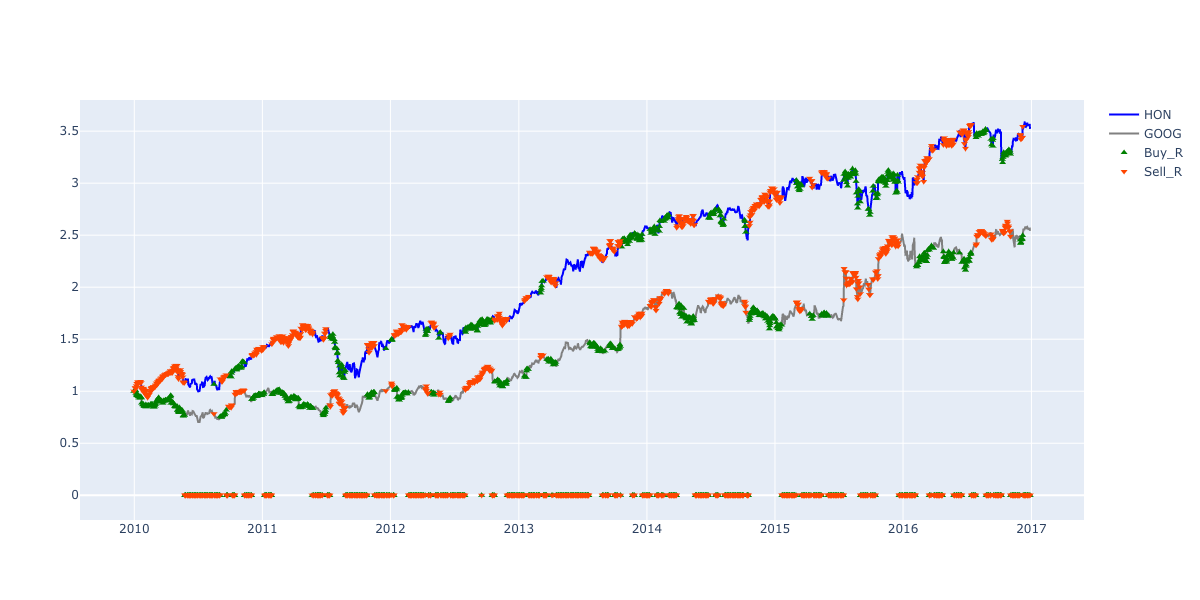

In [36]:
#Plot this bitch
random_x = norm_prices_2["Dates"]
random_y0 = norm_prices_2["HON"]
random_y1 = norm_prices_2["GOOG"]
random_y2 = ratios_df_7['buyR']
random_y3 = ratios_df_7['sellR']

#Prices -- NORMALISED
fig = go.Figure()
fig.add_trace(go.Scatter(x=random_x, y=random_y0,
                    mode='lines',
                    name='HON', 
                    line=dict(color='blue', width=2)))
fig.add_trace(go.Scatter(x=random_x, y=random_y1,
                    mode='lines',
                    name='GOOG', 
                    line=dict(color='grey', width=2)))

#Markers 
fig.add_trace(go.Scatter(x=random_x, y=random_y2,
                    mode='markers', marker_symbol="triangle-up",
                    name='Buy_R', 
                    marker=dict(color='green',
                    size=6,
                    opacity=1)))
fig.add_trace(go.Scatter(x=random_x, y=random_y3,
                    mode='markers', marker_symbol="triangle-down",
                    name='Sell_R', 
                    marker=dict(color='orangered',
                    size=6,
                    opacity=1)))

fig.show(renderer="png", width=1200, height=600)

Now it is time to see the profit/losses this trading strategy may or may not produce. The investor should therefore make a backtest where:
- investor buys 1 ratio (buy 1 HON stock and sell ratio x GOOG stock) when ratio is low
- sell 1 ratio (sell 1 HON stock and buy ratio x GOOG stock) when it’s high 
and calculate PnL of these trades.


In [999]:
def pairs_algo(S1, S2, window1, window2):
    
    # If window length is 0 exit (trading window does not make sense)
    if (window1 == 0) or (window2 == 0):
        return 0
    
    # Compute rolling mean and rolling standard deviation
    ratios = S1/S2
    ma1 = ratios.rolling(window=window1,
                               center=False).mean()
    ma2 = ratios.rolling(window=window2,
                               center=False).mean()
    std = ratios.rolling(window=window2,
                        center=False).std()
    zscore = (ma1 - ma2)/std
    
    # Simulate trading
    # Start with no money and no positions
    money = 0
    countS1 = 0
    countS2 = 0
    for i in range(len(ratios)):
        # Short if the z-score is > 1
        if zscore[i] > 1:
            money += S1[i] - S2[i] * ratios[i]
            countS1 -= 1
            countS2 += ratios[i]
            print('Selling Ratio %s %s %s %s'%(money, ratios[i], countS1,countS2))
        # Long if the z-score is < 1
        elif zscore[i] < -1:
            money -= S1[i] - S2[i] * ratios[i]
            countS1 += 1
            countS2 -= ratios[i]
            print('Buying Ratio %s %s %s %s'%(money,ratios[i], countS1,countS2))
        # Clear positions if the z-score between -.5 and .5
        elif abs(zscore[i]) < 0.75:
            money += S1[i] * countS1 + S2[i] * countS2
            countS1 = 0
            countS2 = 0
            print('Exit pos %s %s %s %s'%(money,ratios[i], countS1,countS2))
            
            
    return money

trade(spx_prices['HON'].iloc[:train_value], spx_prices['GOOG'].iloc[:train_value], 60, 5)

Buying Ratio 0.0 0.12125927305218114 1 -0.12125927305218114
Buying Ratio 0.0 0.1205623890847263 2 -0.24182166213690742
Buying Ratio 0.0 0.12133285502847198 3 -0.3631545171653794
Buying Ratio 0.0 0.12033313554676928 4 -0.48348765271214866
Buying Ratio 0.0 0.12098544529623544 5 -0.6044730980083841
Buying Ratio 0.0 0.1216061414657456 6 -0.7260792394741297
Buying Ratio 0.0 0.12204967440015889 7 -0.8481289138742886
Buying Ratio 0.0 0.12184298970661454 8 -0.9699719035809031
Buying Ratio 0.0 0.12286795633037902 9 -1.092839859911282
Buying Ratio 0.0 0.1220551906987252 10 -1.2148950506100074
Buying Ratio 0.0 0.11827988648679125 11 -1.3331749370967987
Buying Ratio 0.0 0.1195610709850283 12 -1.452736008081827
Buying Ratio 0.0 0.11865324534160532 13 -1.5713892534234324
Buying Ratio 0.0 0.12659508665814848 14 -1.6979843400815808
Buying Ratio 0.0 0.1264131855217992 15 -1.82439752560338
Buying Ratio 0.0 0.1270133408875698 16 -1.9514108664909497
Buying Ratio 7.105427357601002e-15 0.1280329680191889 17

Exit pos 62.071273422118 0.15044988572147028 0 0
Exit pos 62.071273422118 0.15124506648968636 0 0
Exit pos 62.071273422118 0.14930036117604353 0 0
Exit pos 62.071273422118 0.15066331303676903 0 0
Exit pos 62.071273422118 0.15001727883888485 0 0
Exit pos 62.071273422118 0.14790704971314556 0 0
Selling Ratio 62.071273422118 0.1465235048430245 -1 0.1465235048430245
Selling Ratio 62.071273422118 0.14727738965428472 -2 0.29380089449730923
Selling Ratio 62.07127342211799 0.14700280949340103 -3 0.4408037039907102
Selling Ratio 62.07127342211799 0.1480328898602323 -4 0.5888365938509426
Selling Ratio 62.07127342211799 0.1481181386222435 -5 0.736954732473186
Selling Ratio 62.07127342211799 0.14910663884621825 -6 0.8860613713194042
Selling Ratio 62.07127342211799 0.14882599456786147 -7 1.0348873658872657
Selling Ratio 62.07127342211799 0.1466625210962916 -8 1.1815498869835572
Selling Ratio 62.07127342211799 0.1455385539540697 -9 1.327088440937627
Selling Ratio 62.07127342211799 0.1472595077910824

Buying Ratio 456.61498589364044 0.13293527078569453 7 -0.9195485403386485
Buying Ratio 456.61498589364044 0.13325384464200546 8 -1.052802384980654
Buying Ratio 456.61498589364044 0.1296188041598871 9 -1.1824211891405412
Buying Ratio 456.61498589364044 0.13045492134503472 10 -1.312876110485576
Buying Ratio 456.61498589364044 0.12933733414497167 11 -1.4422134446305477
Buying Ratio 456.61498589364044 0.1293075296670209 12 -1.5715209742975687
Buying Ratio 456.61498589364044 0.12799119397756223 13 -1.6995121682751309
Buying Ratio 456.61498589364044 0.12722135571746768 14 -1.8267335239925986
Buying Ratio 456.61498589364044 0.1290052490523252 15 -1.9557387730449238
Buying Ratio 456.61498589364044 0.12975353165040393 16 -2.085492304695328
Buying Ratio 456.61498589364044 0.1327565013169225 17 -2.2182488060122503
Buying Ratio 456.61498589364044 0.13325166722159154 18 -2.351500473233842
Buying Ratio 456.61498589364044 0.1354101026901881 19 -2.48691057592403
Buying Ratio 456.61498589364044 0.13578

1066.0736655902042

In [1107]:
#Now on test data
trade(spx_prices['HON'].iloc[train_value:], spx_prices['GOOG'].iloc[train_value:], 40, 5)

Buying Ratio 1.4210854715202004e-14 0.13563842706413903 1 -0.13563842706413903
Buying Ratio 1.4210854715202004e-14 0.1362118667447935 2 -0.27185029380893255
Buying Ratio 0.0 0.13721538021064889 3 -0.40906567401958144
Buying Ratio -1.4210854715202004e-14 0.13697938840955887 4 -0.5460450624291403
Buying Ratio -1.4210854715202004e-14 0.13710510697164024 5 -0.6831501694007805
Buying Ratio -1.4210854715202004e-14 0.1371789752039986 6 -0.8203291446047791
Buying Ratio -2.842170943040401e-14 0.1366928263384635 7 -0.9570219709432426
Buying Ratio -4.263256414560601e-14 0.13648245939745016 8 -1.0935044303406927
Buying Ratio -4.263256414560601e-14 0.1355142423734982 9 -1.229018672714191
Buying Ratio -4.263256414560601e-14 0.13568768471594278 10 -1.3647063574301337
Buying Ratio -4.263256414560601e-14 0.1349899919347894 11 -1.4996963493649231
Buying Ratio -2.842170943040401e-14 0.13389083135914487 12 -1.633587180724068
Buying Ratio -1.4210854715202004e-14 0.1349806383404086 13 -1.7685678190644767
Bu

-1127.41028979446

Curiosity: CSS Colors for PlotLy 
    
aliceblue, antiquewhite, aqua, aquamarine, azure,
beige, bisque, black, blanchedalmond, blue,
blueviolet, brown, burlywood, cadetblue,
chartreuse, chocolate, coral, cornflowerblue,
cornsilk, crimson, cyan, darkblue, darkcyan,
darkgoldenrod, darkgray, darkgrey, darkgreen,
darkkhaki, darkmagenta, darkolivegreen, darkorange,
darkorchid, darkred, darksalmon, darkseagreen,
darkslateblue, darkslategray, darkslategrey,
darkturquoise, darkviolet, deeppink, deepskyblue,
dimgray, dimgrey, dodgerblue, firebrick,
floralwhite, forestgreen, fuchsia, gainsboro,
ghostwhite, gold, goldenrod, gray, grey, green,
greenyellow, honeydew, hotpink, indianred, indigo,
ivory, khaki, lavender, lavenderblush, lawngreen,
lemonchiffon, lightblue, lightcoral, lightcyan,
lightgoldenrodyellow, lightgray, lightgrey,
lightgreen, lightpink, lightsalmon, lightseagreen,
lightskyblue, lightslategray, lightslategrey,
lightsteelblue, lightyellow, lime, limegreen,
linen, magenta, maroon, mediumaquamarine,
mediumblue, mediumorchid, mediumpurple,
mediumseagreen, mediumslateblue, mediumspringgreen,
mediumturquoise, mediumvioletred, midnightblue,
mintcream, mistyrose, moccasin, navajowhite, navy,
oldlace, olive, olivedrab, orange, orangered,
orchid, palegoldenrod, palegreen, paleturquoise,
palevioletred, papayawhip, peachpuff, peru, pink,
plum, powderblue, purple, red, rosybrown,
royalblue, saddlebrown, salmon, sandybrown,
seagreen, seashell, sienna, silver, skyblue,
slateblue, slategray, slategrey, snow, springgreen,
steelblue, tan, teal, thistle, tomato, turquoise,
violet, wheat, white, whitesmoke, yellow,
yellowgreen

Future dev: 
- Apply Kalman filters
- Improve the Z-Score (logistic regression? whatever) 
- Change the MAvg as entry/exit signals. What's a better way to deal with this? 
- Run a PTF of multiple pairs trade with optimisation techniques 